In [1]:
#import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
#Date Range chosen as 1 August 2017 to 15 August 2017.

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
inspector = inspect(engine)
# reflect the tables
inspector.get_table_names()

['measurement', 'station']

In [6]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
# Use `engine.execute` to select and display the first rows from 'measurement' table
engine.execute('SELECT * FROM measurement LIMIT 3').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0)]

In [8]:
# We can view all of the classes that automap found
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Use `engine.execute` to select and display the first rows from 'station' table
engine.execute('SELECT * FROM station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [10]:
#Save references to each table
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement_Table = Base.classes.measurement
Station_Table = Base.classes.station

In [11]:
#Start a session to query the database
session = Session(engine)

In [12]:
# Query Measurement_Table and save the query into results
results = session.query(Measurement_Table.id, Measurement_Table.station, Measurement_Table.date, Measurement_Table.prcp, Measurement_Table.tobs).all()
# Load the results into a pandas dataframe. Set the index to the `Measurement_Table.id`
Measurement_df = pd.DataFrame(results[:], columns=['Measurement_Table.id', 'Measurement_Table.station', 'Measurement_Table.date', 'Measurement_Table.prcp', 'Measurement_Table.tobs'])
Measurement_df.set_index('Measurement_Table.id', inplace=True, )
Measurement_df.tail(3)

,Measurement_Table.station,Measurement_Table.date,Measurement_Table.prcp,Measurement_Table.tobs
Measurement_Table.id,,,,
19548,USC00516128,2017-08-21,0.56,76.0
19549,USC00516128,2017-08-22,0.50,76.0
19550,USC00516128,2017-08-23,0.45,76.0


In [13]:
# Query Station_Table and save the query into results
results = session.query(Station_Table.id, Station_Table.station, Station_Table.name,Station_Table.latitude,Station_Table.longitude, Station_Table.elevation).all()
# Load the results into a pandas dataframe. Set the index to the `Station_Table.id`
Station_df = pd.DataFrame(results[:], columns=['Station_Table.id','Station_Table.station','Station_Table.name','Station_Table.latitude','Station_Table.longitude', 'Station_Table.elevation'])
Station_df.set_index('Station_Table.id', inplace=True, )
Station_df.tail(3)

,Station_Table.station,Station_Table.name,Station_Table.latitude,Station_Table.longitude,Station_Table.elevation
Station_Table.id,,,,,
7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


# Exploratory Climate Analysis

In [14]:
#Find last twelve months with Pandas
end_date = Measurement_df.loc[19550,'Measurement_Table.date']
year_earlier_date = Measurement_df.loc[19550-365,'Measurement_Table.date']
print(year_earlier_date)
print(end_date)

2016-08-06
2017-08-23


In [15]:
#Find last twelve months with SQL
end_date = session.query(Measurement_Table.date).order_by(Measurement_Table.date.desc()).first()
end_date = dt.datetime.strptime((*end_date), '%Y-%m-%d')
year_earlier_date = end_date - dt.timedelta(days=365)
print(year_earlier_date)
print(end_date)
#This way is more accurate, because the table doesn't have data for every day.

2016-08-23 00:00:00
2017-08-23 00:00:00


In [16]:
# Perform a query to retrieve the data and precipitation scores from the last twelve months of data.
query = [Measurement_Table.date, Measurement_Table.prcp]
rainfall = session.query(*query).filter(Measurement_Table.date >= year_earlier_date).all()

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column. Sort the dataframe by date
rainfall_df = pd.DataFrame(rainfall)
rainfall_df.set_index('date', inplace=True)
rainfall_df = rainfall_df.sort_values("date", ascending=True)
rainfall_df.tail()

,prcp
date,
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.45


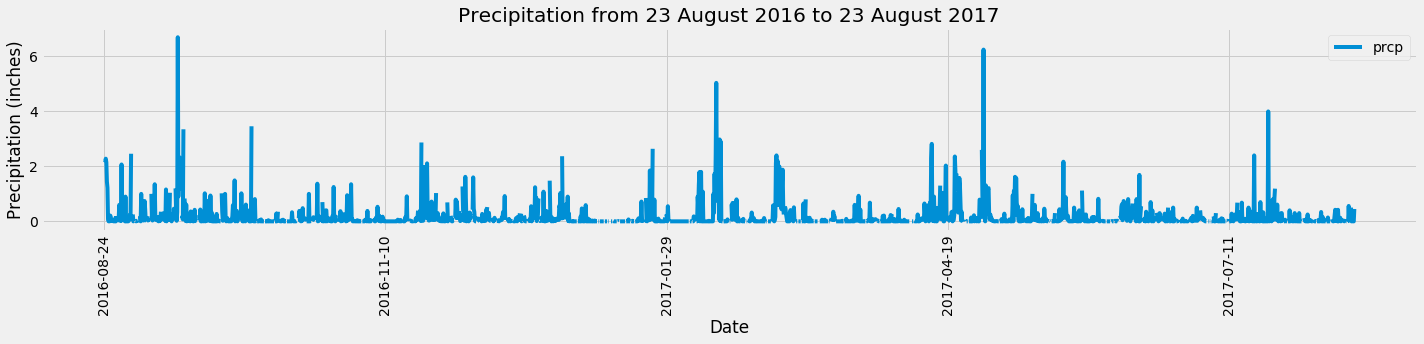

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
rainfall_df.plot(figsize=(20,5), rot=90)
plt.title("Precipitation from 23 August 2016 to 23 August 2017")
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rainfall_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
x = len(Measurement_df['Measurement_Table.station'].unique())
print(f'There are {len(Station_df)} stations in the Station table, and {x} in the Measurement table.')

There are 9 stations in the Station table, and 9 in the Measurement table.


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Station_Counts_df = pd.DataFrame(Measurement_df['Measurement_Table.station'].value_counts())
Station_Counts_df

,Measurement_Table.station
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [22]:
#Choose the most active station
Most_Active_Station = Station_Counts_df.index[0]
Most_Active_Station

'USC00519281'

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature of the most active station?
Most_Active_df = Measurement_df.loc[Measurement_df["Measurement_Table.station"] == Most_Active_Station]
min_temp = Most_Active_df['Measurement_Table.tobs'].min()
max_temp = Most_Active_df['Measurement_Table.tobs'].max()
avg_temp = round(Most_Active_df['Measurement_Table.tobs'].mean(),1)
print(f'The min temperature recorded in the database for station {Most_Active_Station} is {min_temp} deg F.')
print(f'The lowest temperature recorded in the database for station {Most_Active_Station} is {max_temp} deg F.')
print(f'The average temperature recorded in the database for station {Most_Active_Station} is {avg_temp} deg F.')

The min temperature recorded in the database for station USC00519281 is 54.0 deg F.
The lowest temperature recorded in the database for station USC00519281 is 85.0 deg F.
The average temperature recorded in the database for station USC00519281 is 71.7 deg F.


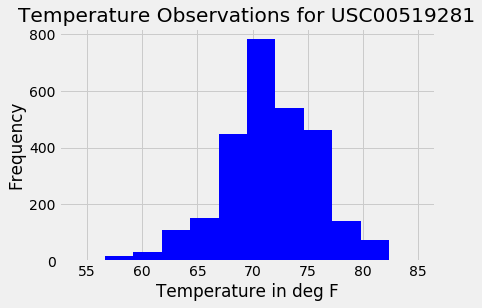

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the temperature observation data for this station and plot the results as a histogram
plt.hist(Most_Active_df['Measurement_Table.tobs'], bins = 12, color="b")
plt.title("Temperature Observations for USC00519281")
plt.ylabel("Frequency")
plt.xlabel("Temperature in deg F")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
